In [329]:
# Sesión de Spark
from pyspark.sql import SparkSession

# Transformaciones sobre columnas
from pyspark.sql.functions import col, when, isnan, count,regexp_replace, expr, lit, percentile_approx, first
from pyspark.sql import functions as F
from pyspark.sql.functions import col as spark_col

# Preprocesamiento
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline

# Modelos supervisados
from pyspark.ml.classification import RandomForestClassifier

# Modelos no supervisados
from pyspark.ml.clustering import KMeans

# Evaluación
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator

#Visualización y análisis con Pandas y Matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [303]:
spark = SparkSession.builder.appName("BLUETAP").getOrCreate()
spark

In [304]:
df_excel = pd.read_excel("E:\Python\Test\database\default of credit card clients.xls", engine='xlrd',header=None)# Leer el archivo Excel sin encabezado (header=None) usando el motor 'xlrd'
df_excel.columns = df_excel.iloc[1] # Asignar los nombres de las columnas usando la segunda fila (índice 1)
df_excel = df_excel.iloc[2:]# Eliminar las dos primeras filas del DataFrame
df_excel = df_excel.reset_index(drop=True) # Reiniciar el índice para que empiece desde 0 y se eliminen los índices originales
df_excel.to_csv("E:/Python/Test/default_of_credit_card_clients.csv", index=False)# Guardar el DataFrame limpio como archivo CSV sin incluir el índice como columna


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Oscar\AppData\Local\Temp\ipykernel_24680\2335813214.py:1: SyntaxWarning: invalid escape sequence '\P'
  df_excel = pd.read_excel("E:\Python\Test\database\default of credit card clients.xls", engine='xlrd',header=None)# Leer el archivo Excel sin encabezado (header=None) usando el motor 'xlrd'


In [305]:
# Cargar el dataset 
df = spark.read.csv("E:\Python\Test\default_of_credit_card_clients.csv", header=True, inferSchema=True)

# Mostrar las primeras filas
df.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Oscar\AppData\Local\Temp\ipykernel_24680\3426733072.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = spark.read.csv("E:\Python\Test\default_of_credit_card_clients.csv", header=True, inferSchema=True)


In [306]:
# Ver cuántos valores nulos hay por columna 
print("Valores nulos por columna:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(truncate=False)


Valores nulos por columna:
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|ID |LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|0  |0        |0  |0        |0       |0  |0    |0    |0    |0    |0    |0    |0        |0        |0        |0        |0        |0        |0       |0       |0       |0       |0       |0       |0                         |
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+-----

In [307]:
df.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|               ID|         LIMIT_BAL|               SEX|         EDUCATION|          MARRIAGE|              AGE|             PAY_0|               PAY_2|             PAY_3|               PAY_4|             PAY_5|            PAY_6|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|         BILL_AMT4|        BILL_AMT5|       BILL_AMT6|         PAY_AMT1|          PAY_AMT2|         PAY_AMT3|          PAY_AMT4|          PAY_AMT5|         PAY_AMT6|default payment next month|
+-------+-----------------+---

In [308]:
#Revisión de columnas categóricas
df.groupBy("SEX").count().orderBy("count", ascending=False).show()
df.groupBy("EDUCATION").count().orderBy("count", ascending=False).show()
df.groupBy("MARRIAGE").count().orderBy("count", ascending=False).show()
df.groupBy("MARRIAGE").count().orderBy("count", ascending=False).show()
df.groupBy("PAY_0").count().orderBy("count", ascending=False).show()


+---+-----+
|SEX|count|
+---+-----+
|  2|18112|
|  1|11888|
+---+-----+

+---------+-----+
|EDUCATION|count|
+---------+-----+
|        2|14030|
|        1|10585|
|        3| 4917|
|        5|  280|
|        4|  123|
|        6|   51|
|        0|   14|
+---------+-----+

+--------+-----+
|MARRIAGE|count|
+--------+-----+
|       2|15964|
|       1|13659|
|       3|  323|
|       0|   54|
+--------+-----+

+--------+-----+
|MARRIAGE|count|
+--------+-----+
|       2|15964|
|       1|13659|
|       3|  323|
|       0|   54|
+--------+-----+

+-----+-----+
|PAY_0|count|
+-----+-----+
|    0|14737|
|   -1| 5686|
|    1| 3688|
|   -2| 2759|
|    2| 2667|
|    3|  322|
|    4|   76|
|    5|   26|
|    8|   19|
|    6|   11|
|    7|    9|
+-----+-----+



In [309]:
total_count = df.count()
df.groupBy('default payment next month').count() \
    .withColumn("porcentaje", round(col("count") / total_count * 100, 2)) \
    .show()


+--------------------------+-----+----------+
|default payment next month|count|porcentaje|
+--------------------------+-----+----------+
|                         1| 6636|     22.12|
|                         0|23364|     77.88|
+--------------------------+-----+----------+



In [310]:
# Reagrupar EDUCATION: valores 5 y 6 → 5 ("unknown")
df = df.withColumn(
    "EDUCATION",
    when((df["EDUCATION"] == 5) | (df["EDUCATION"] == 6), 5).otherwise(df["EDUCATION"])
)

#Limpieza de valores inválidos
df = df.filter(df["EDUCATION"] != 0)
df = df.filter(df["MARRIAGE"] != 0)

#Revisión de columnas categóricas modificadas 
df.groupBy("EDUCATION").count().orderBy("count", ascending=False).show()
df.groupBy("MARRIAGE").count().orderBy("count", ascending=False).show()

+---------+-----+
|EDUCATION|count|
+---------+-----+
|        2|14024|
|        1|10581|
|        3| 4873|
|        5|  331|
|        4|  123|
+---------+-----+

+--------+-----+
|MARRIAGE|count|
+--------+-----+
|       2|15954|
|       1|13655|
|       3|  323|
+--------+-----+



In [331]:
import builtins  

cols = df.columns
correlations = []

for col1 in cols:
    row = []
    for col2 in cols:
        corr_value = df.select(col1, col2).corr(col1, col2)
        row.append(builtins.round(corr_value, 4))  # Aquí ya es seguro
    correlations.append(row)

corr_df = pd.DataFrame(correlations, columns=cols, index=cols)




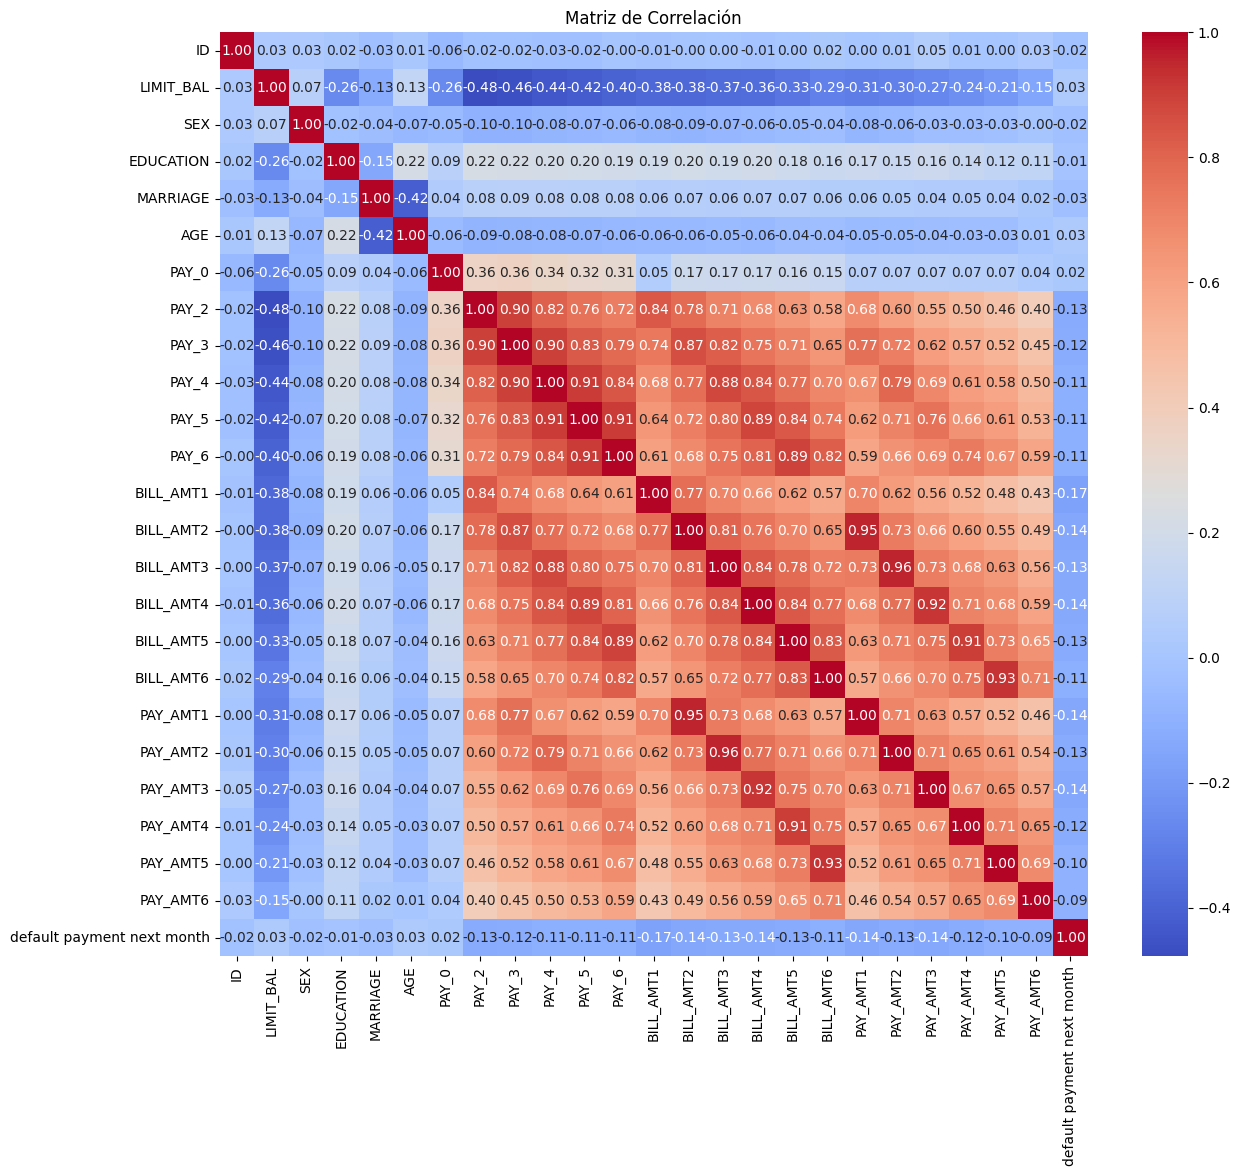

In [332]:
plt.figure(figsize=(14, 12))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()


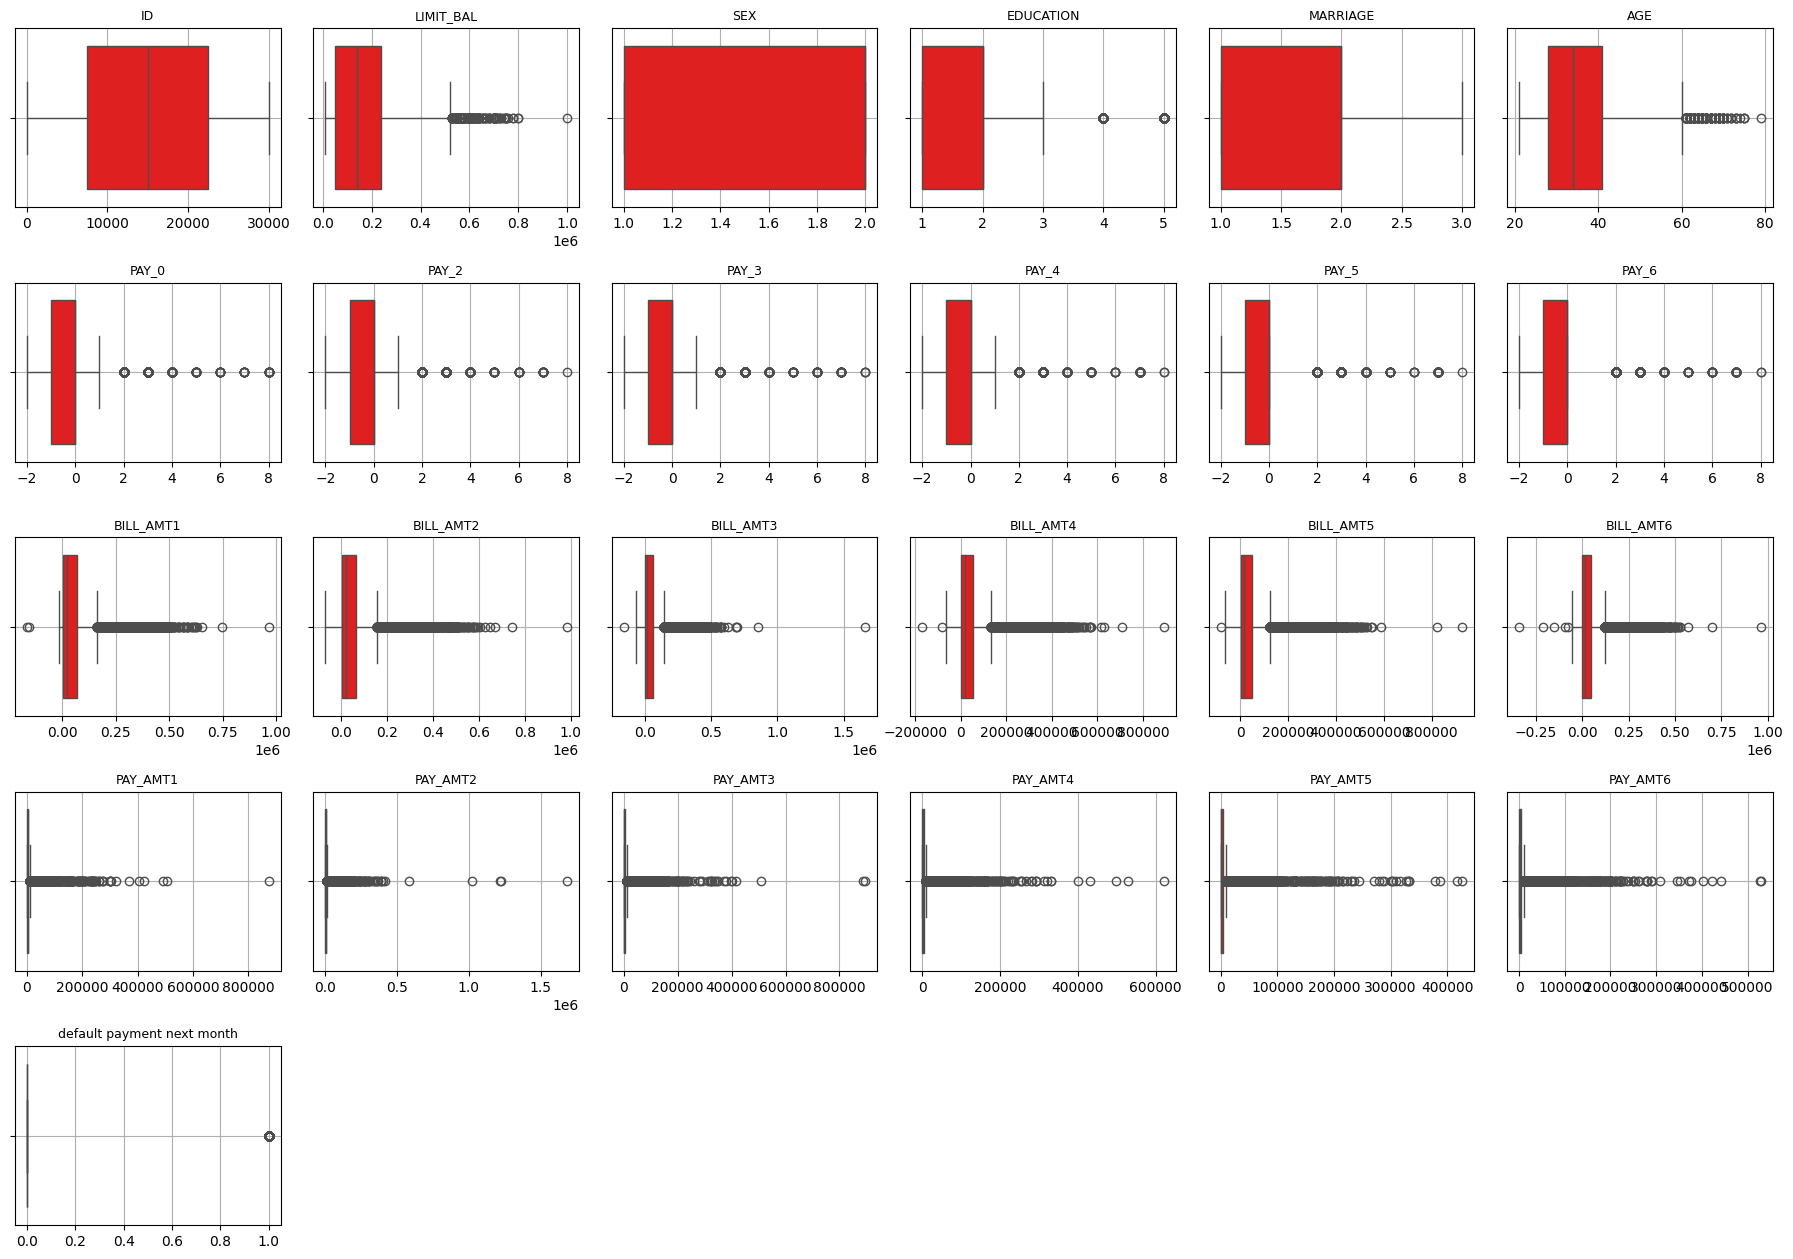

In [311]:
df_pd = df.toPandas()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15)) 
axes = axes.flatten()

for i, col in enumerate(df.columns):  
    sns.boxplot(x=df_pd[col].dropna(), ax=axes[i], color="red")
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

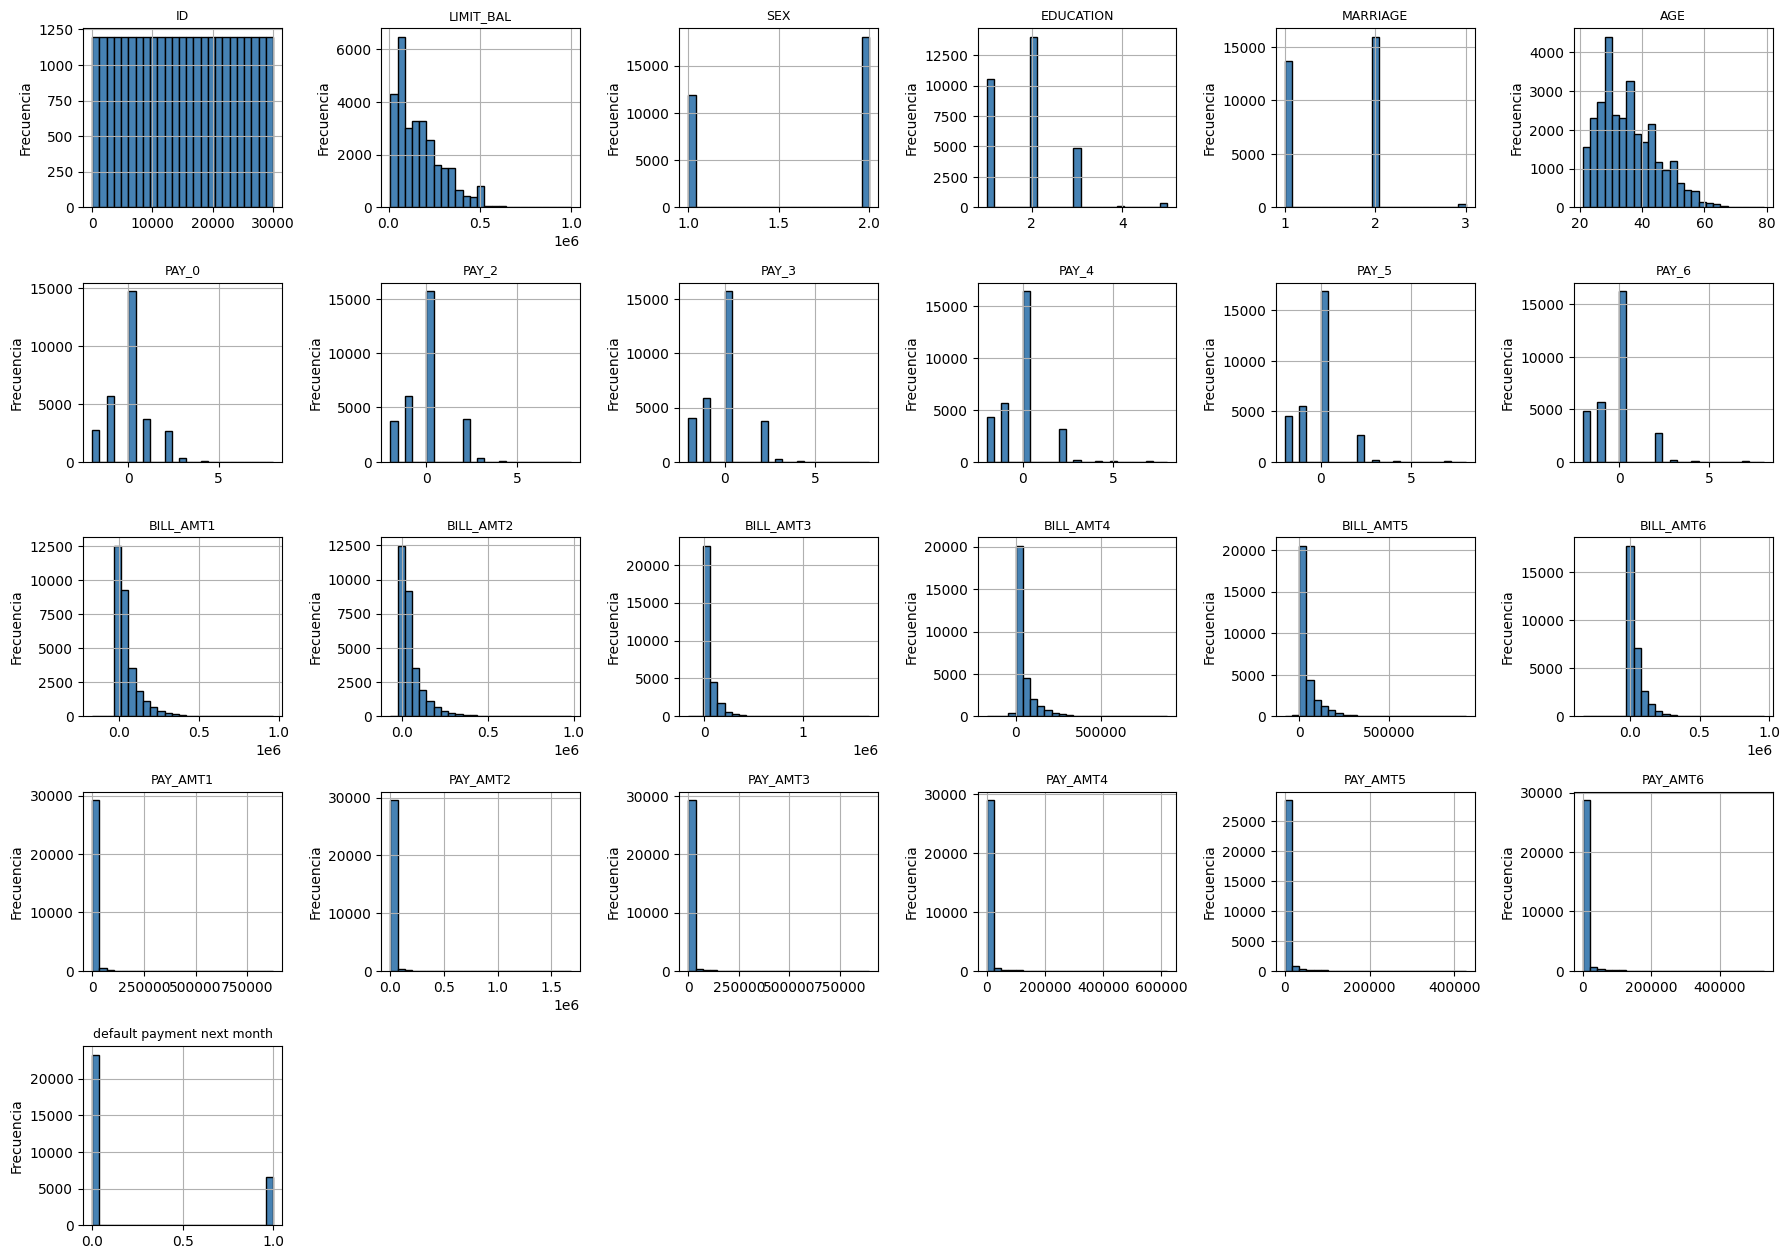

In [313]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15))  
axes = axes.flatten()


for i, col in enumerate(df.columns):
    axes[i].hist(df_pd[col].dropna(), bins=25, color='steelblue', edgecolor='black')
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")  
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(True)

# Ocultar subplots vacíos si hay más ejes que columnas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [314]:

py_round = __builtins__.round 

def eliminar_outliers_spark(df, columnas):
    for nombre_col in columnas:
        # Calcular Q1 y Q3
        q1, q3 = df.approxQuantile(nombre_col, [0.25, 0.75], 0.01)
        iqr = q3 - q1
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr

        # Filtrar fuera del IQR
        df = df.filter(
            (spark_col(nombre_col) >= limite_inferior) & (spark_col(nombre_col) <= limite_superior)
        )
        
    return df

In [315]:
df = eliminar_outliers_spark(df, df.drop('default payment next month').columns)


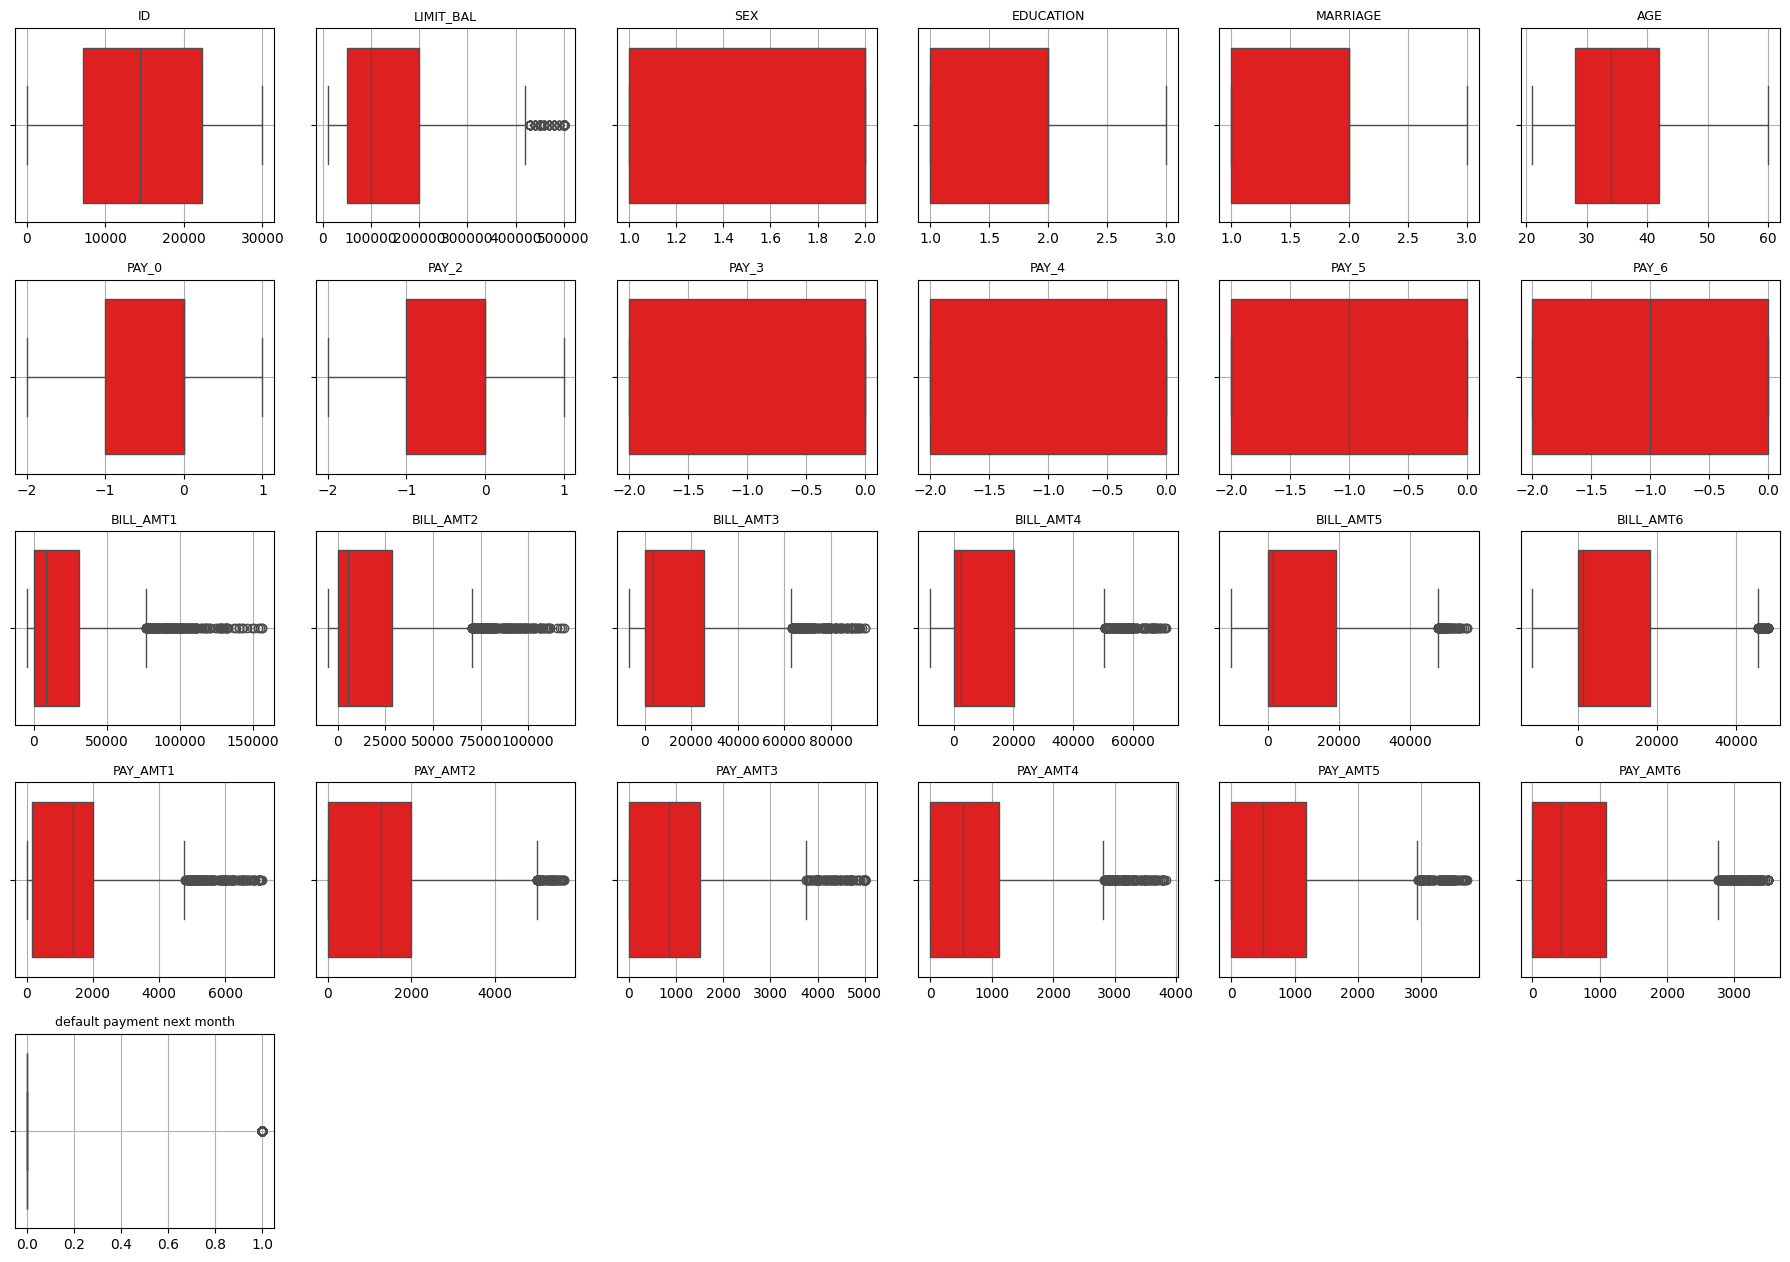

In [316]:
df_pd = df.toPandas()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15)) 
axes = axes.flatten()

for i, col in enumerate(df.columns):  
    sns.boxplot(x=df_pd[col].dropna(), ax=axes[i], color="red")
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

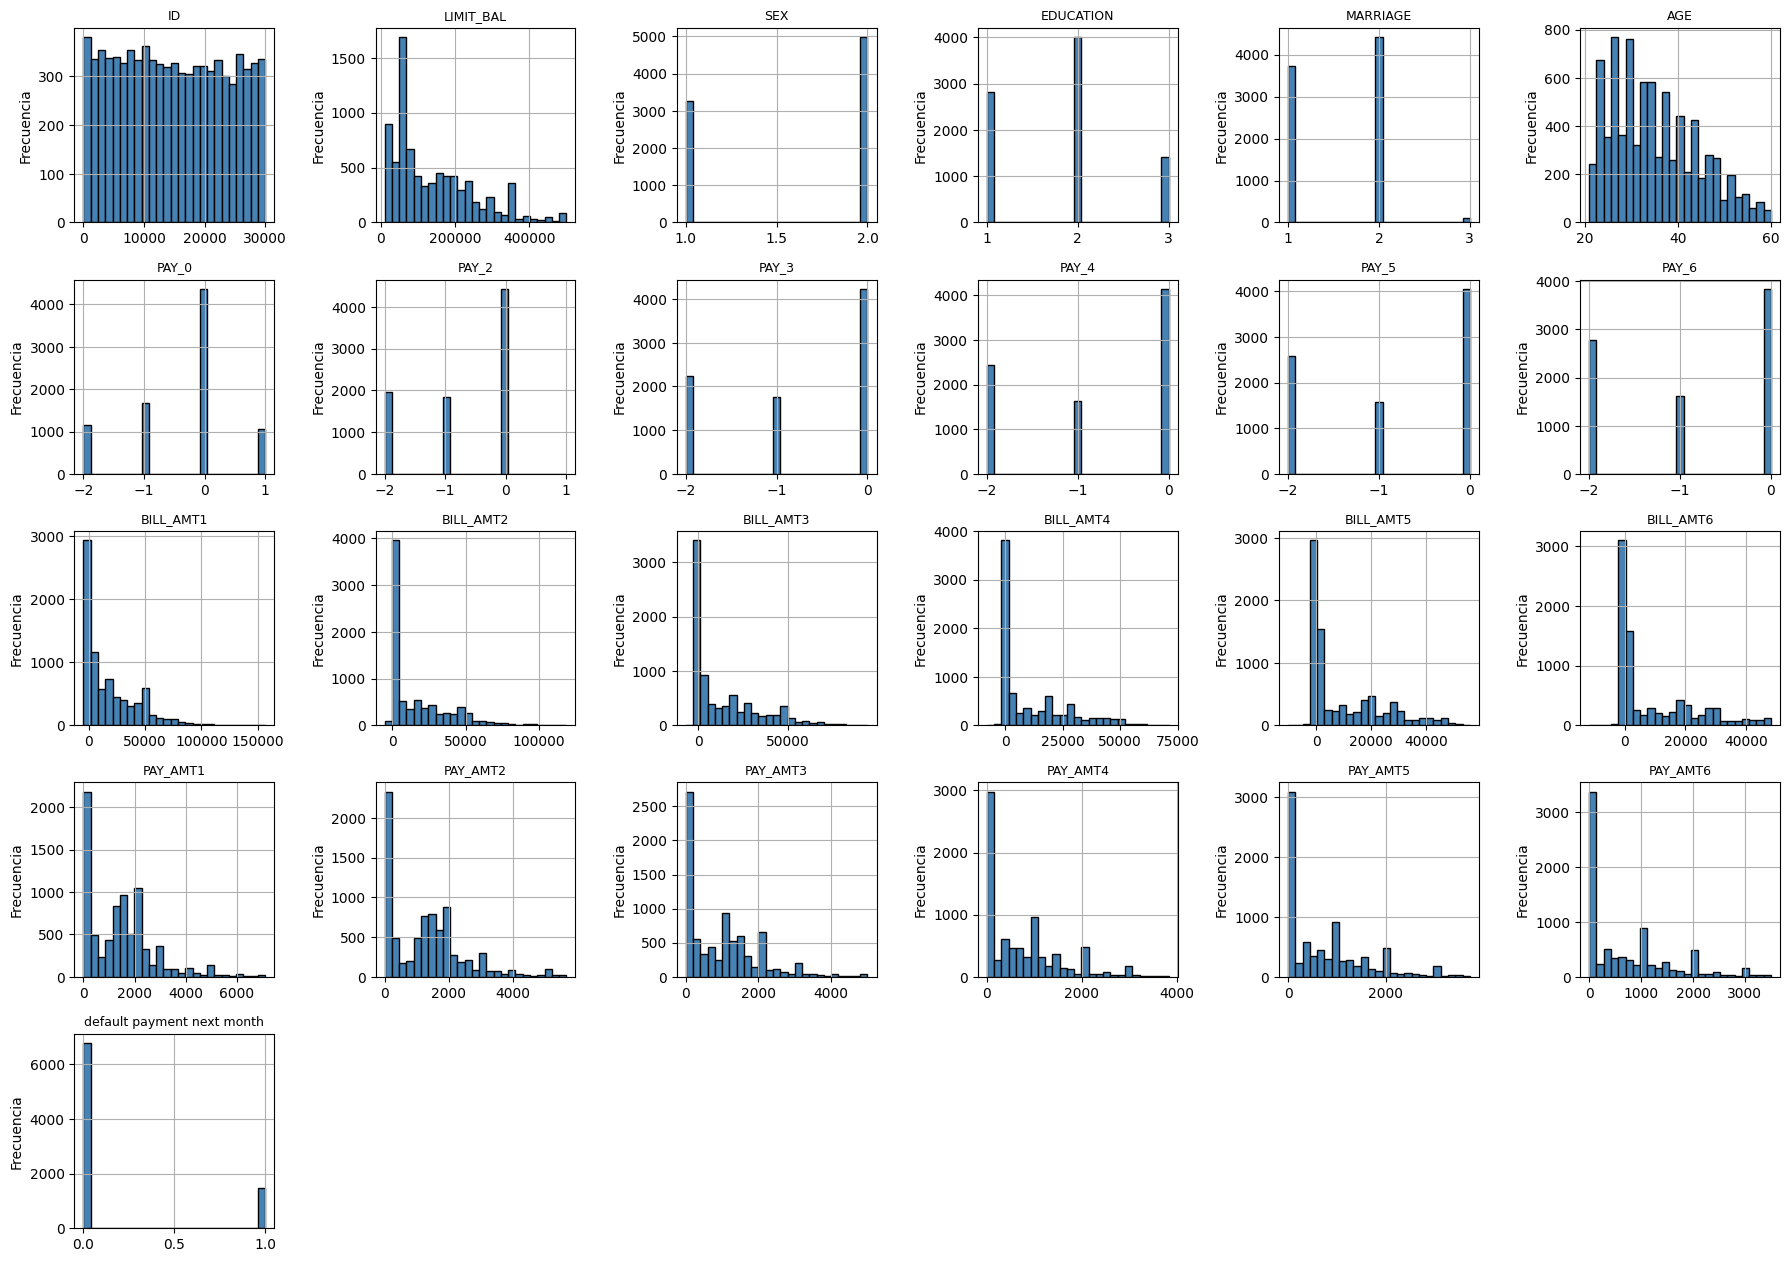

In [317]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15))  
axes = axes.flatten()


for i, col in enumerate(df.columns):
    axes[i].hist(df_pd[col].dropna(), bins=25, color='steelblue', edgecolor='black')
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")  
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(True)

# Ocultar subplots vacíos si hay más ejes que columnas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [318]:
from pyspark.sql.functions import log1p, col

log_cols = [
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"
]

for col_name in log_cols:
    df = df.withColumn(f"{col_name}", log1p(col(col_name)))


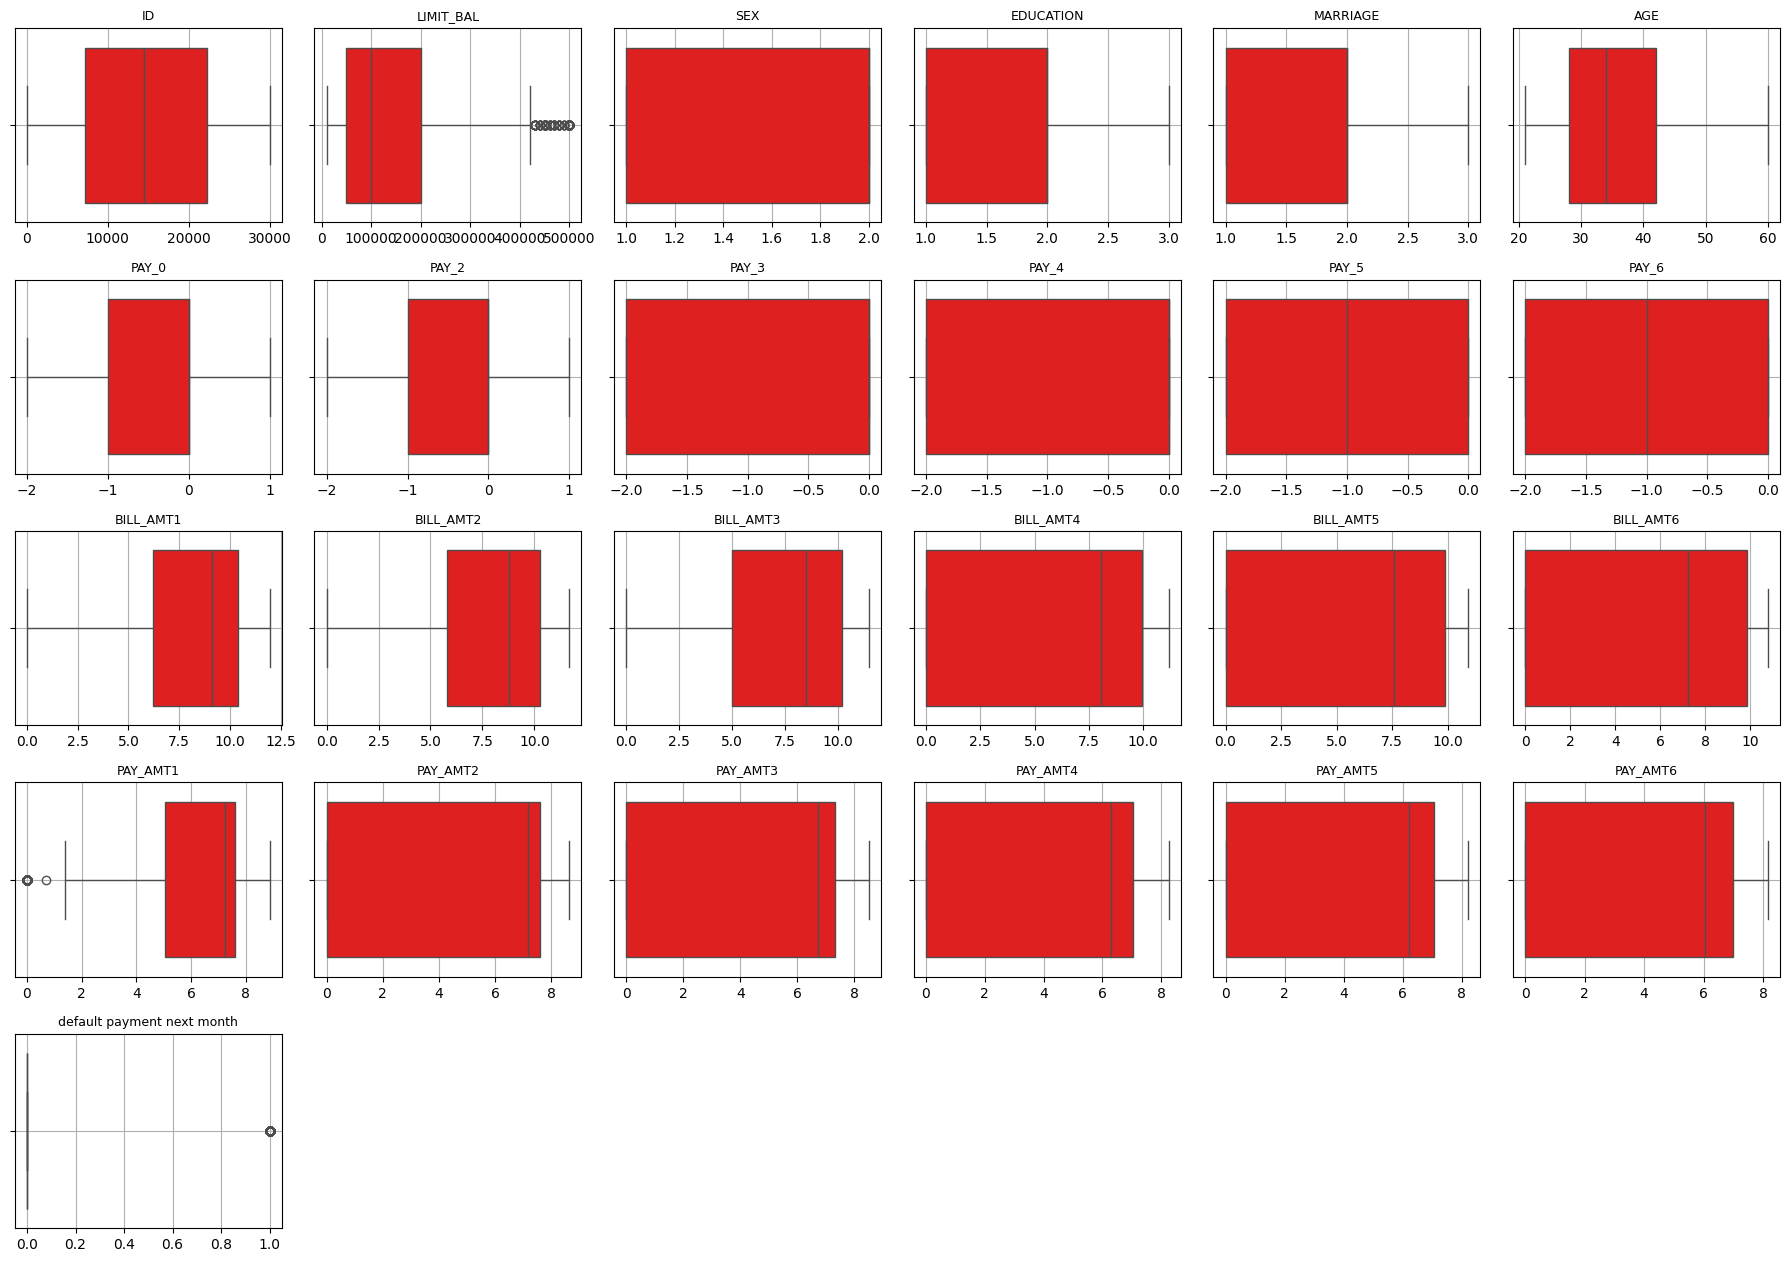

In [319]:
df_pd = df.toPandas()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15)) 
axes = axes.flatten()

for i, col in enumerate(df.columns):  
    sns.boxplot(x=df_pd[col].dropna(), ax=axes[i], color="red")
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

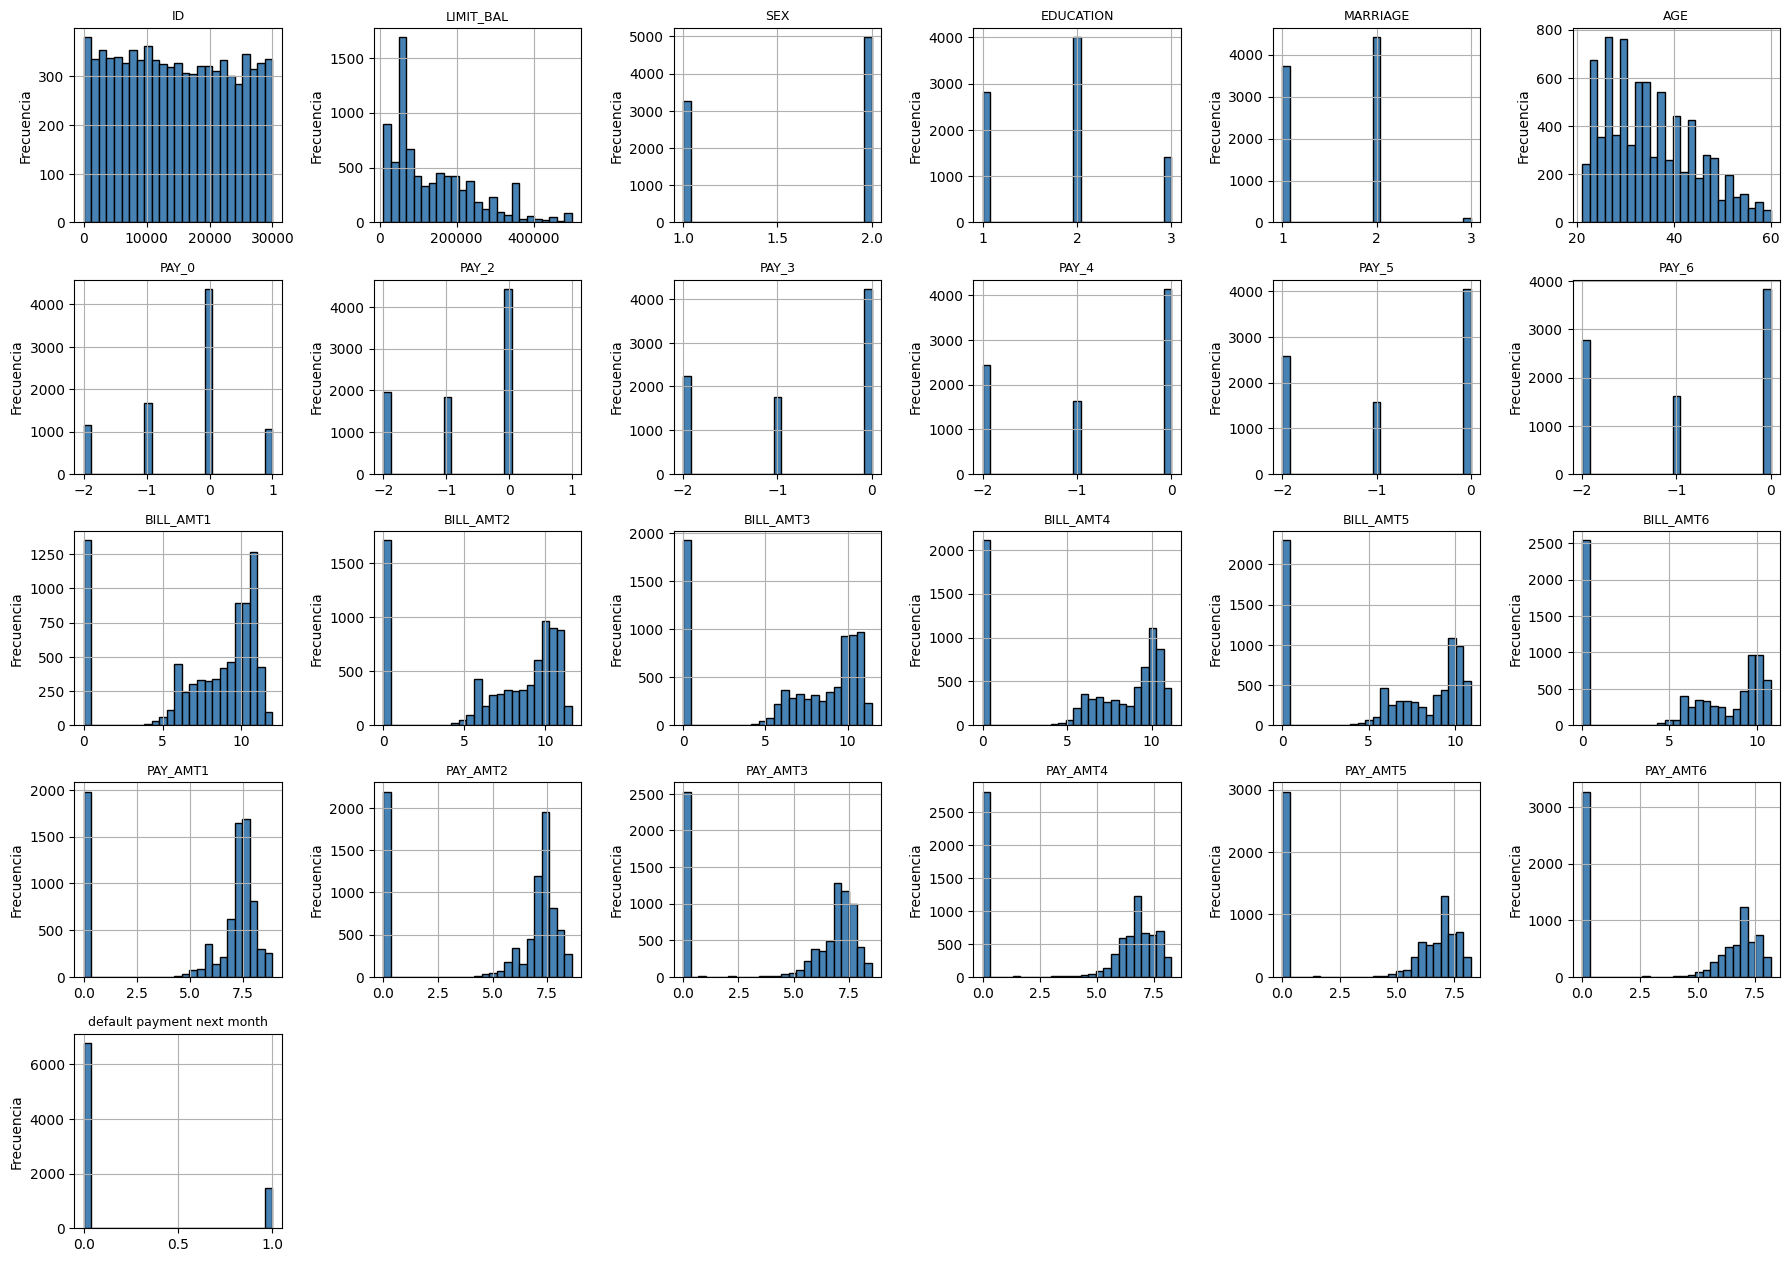

In [320]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 15))  
axes = axes.flatten()


for i, col in enumerate(df.columns):
    axes[i].hist(df_pd[col].dropna(), bins=25, color='steelblue', edgecolor='black')
    axes[i].set_title(f"{col}", fontsize=9)
    axes[i].set_xlabel("")  
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(True)

# Ocultar subplots vacíos si hay más ejes que columnas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [249]:
# Creacion de DF por Modelo
df_P4 = df.select(
    "PAY_AMT4",  # variable objetivo
    "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
    "PAY_5", "PAY_6",
    "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT5", "PAY_AMT6"
)

df_DFNM = df.select(
    "default payment next month",  # variable objetivo
    "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
    "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"
)


In [250]:
#Variables nuevas por modelo
df_P4 = df_P4.withColumn("AVG_DELAY_56", expr("(PAY_5 + PAY_6) / 2"))

df_P4 = df_P4.withColumn("AVG_PAY_RATIO_56", expr("""
(
    (PAY_AMT5 / (BILL_AMT5 + 1e-5)) +
    (PAY_AMT6 / (BILL_AMT6 + 1e-5))
) / 2
"""))

df_P4 = df_P4.withColumn("TOTAL_PAY_RATIO_56", expr(
    "(PAY_AMT5 + PAY_AMT6) / LIMIT_BAL"
    
))


df_P4 = df_P4.na.fill(0)


df_P4.show(5)


+-----------------+---------+---+---------+--------+---+-----+-----+------------------+------------------+-----------------+-----------------+------------+------------------+--------------------+
|         PAY_AMT4|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_5|PAY_6|         BILL_AMT5|         BILL_AMT6|         PAY_AMT5|         PAY_AMT6|AVG_DELAY_56|  AVG_PAY_RATIO_56|  TOTAL_PAY_RATIO_56|
+-----------------+---------+---+---------+--------+---+-----+-----+------------------+------------------+-----------------+-----------------+------------+------------------+--------------------+
| 7.00397413672268|    50000|  2|        2|       1| 37|    0|    0|10.273670846499652|10.293771338648629|6.975413927455952| 6.90875477931522|         0.0|0.6750588375183635|2.776833741354234...|
| 6.90875477931522|    50000|  1|        1|       2| 37|    0|    0| 9.884304733119354|  9.90473677193656| 6.90875477931522| 6.68586094706836|         0.0|0.6869886351890708|2.718923145276716E-4|
|6.366470447731438| 

In [251]:
#Variables nuevas por modelo
df_DFNM = df_DFNM.withColumn("AVG_DELAY_26", expr(
    "(PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6) / 5"
))

df_DFNM = df_DFNM.withColumn("AVG_PAY_RATIO_26", expr("""
(
    (PAY_AMT2 / (BILL_AMT2 + 1e-5)) +
    (PAY_AMT3 / (BILL_AMT3 + 1e-5)) +
    (PAY_AMT4 / (BILL_AMT4 + 1e-5)) +
    (PAY_AMT5 / (BILL_AMT5 + 1e-5)) +
    (PAY_AMT6 / (BILL_AMT6 + 1e-5))
) / 5
"""))

df_DFNM = df_DFNM.withColumn("TOTAL_PAY_RATIO_26", expr(
    "(PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6) / LIMIT_BAL"
))

df_DFNM = df_DFNM.na.fill(0)
df_DFNM.show(5)

+--------------------------+---------+---+---------+--------+---+-----+-----+-----+-----+-----+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------+------------------+--------------------+
|default payment next month|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|         BILL_AMT2|         BILL_AMT3|         BILL_AMT4|         BILL_AMT5|         BILL_AMT6|         PAY_AMT2|          PAY_AMT3|         PAY_AMT4|         PAY_AMT5|         PAY_AMT6|AVG_DELAY_26|  AVG_PAY_RATIO_26|  TOTAL_PAY_RATIO_26|
+--------------------------+---------+---+---------+--------+---+-----+-----+-----+-----+-----+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------+------------------+-----------------

# **Modelos para predecir la variable PAY_AMT4**

In [252]:
X = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE","PAY_5", "PAY_6", "BILL_AMT5", "BILL_AMT6", "PAY_AMT5", "PAY_AMT6",
                "AVG_DELAY_56", "AVG_PAY_RATIO_56", "TOTAL_PAY_RATIO_56"]

Y =  "PAY_AMT4"

assembler = VectorAssembler(inputCols=X, outputCol="features")

In [253]:
train_df, test_df = df_P4.randomSplit([0.8, 0.2], seed=1)


In [254]:
pipeline = Pipeline(stages=[assembler])
model_pipeline = pipeline.fit(train_df)

train_prepared = model_pipeline.transform(train_df)
test_prepared = model_pipeline.transform(test_df)

In [255]:
from pyspark.ml.regression import LinearRegression


lr = LinearRegression(featuresCol="features", labelCol=Y)
lr_model = lr.fit(train_prepared)

lr_predictions = lr_model.transform(test_prepared)


In [256]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(
    labelCol=Y, predictionCol="prediction", metricName="rmse")

evaluator_mae = RegressionEvaluator(
    labelCol=Y, predictionCol="prediction", metricName="mae")

evaluator_r2 = RegressionEvaluator(
    labelCol=Y, predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(lr_predictions)
mae = evaluator_mae.evaluate(lr_predictions)
r2 = evaluator_r2.evaluate(lr_predictions)

print(f"Resultados Linear Regression:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")


Resultados Linear Regression:
RMSE: 1.22
MAE:  0.69
R²:   0.8589


In [257]:
train_predictions = lr_model.transform(train_prepared)
test_predictions = lr_model.transform(test_prepared)


# Evalúa RMSE en ambos
evaluator = RegressionEvaluator(labelCol="PAY_AMT4", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator.evaluate(train_predictions)
rmse_test = evaluator.evaluate(test_predictions)

print(f"RMSE Entrenamiento: {rmse_train:.2f}")
print(f"RMSE Prueba: {rmse_test:.2f}")


RMSE Entrenamiento: 1.20
RMSE Prueba: 1.22


In [258]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=Y,  
    numTrees=100,
    maxDepth=5,
    seed=1
)


In [259]:
rf_model = rf.fit(train_prepared)
rf_predictions = rf_model.transform(test_prepared)


In [260]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol=Y, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=Y, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=Y, predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(rf_predictions)
mae = evaluator_mae.evaluate(rf_predictions)
r2 = evaluator_r2.evaluate(rf_predictions)

print("Resultados Random Forest Regressor:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")


Resultados Random Forest Regressor:
RMSE: 1.07
MAE:  0.48
R²:   0.8930


In [261]:
train_predictions = rf_model.transform(train_prepared)
test_predictions = rf_model.transform(test_prepared)


# Evalúa RMSE en ambos
evaluator = RegressionEvaluator(labelCol="PAY_AMT4", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator.evaluate(train_predictions)
rmse_test = evaluator.evaluate(test_predictions)

print(f"RMSE Entrenamiento: {rmse_train:.2f}")
print(f"RMSE Prueba: {rmse_test:.2f}")


RMSE Entrenamiento: 1.01
RMSE Prueba: 1.07


In [262]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(
    featuresCol="features",
    labelCol=Y,  
    maxIter=50,
    maxDepth=5,
    seed=1
)


In [263]:
gbt_model = gbt.fit(train_prepared)
gbt_predictions = gbt_model.transform(test_prepared)


In [264]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol=Y, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=Y, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=Y, predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(gbt_predictions)
mae = evaluator_mae.evaluate(gbt_predictions)
r2 = evaluator_r2.evaluate(gbt_predictions)

print("Resultados GBT Regressor:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")


Resultados GBT Regressor:
RMSE: 1.01
MAE:  0.39
R²:   0.9045


In [265]:
train_predictions = gbt_model.transform(train_prepared)
test_predictions = gbt_model.transform(test_prepared)


# Evalúa RMSE en ambos
evaluator = RegressionEvaluator(labelCol="PAY_AMT4", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator.evaluate(train_predictions)
rmse_test = evaluator.evaluate(test_predictions)

print(f"RMSE Entrenamiento: {rmse_train:.2f}")
print(f"RMSE Prueba: {rmse_test:.2f}")

RMSE Entrenamiento: 0.66
RMSE Prueba: 1.01


In [267]:
# Obtener importancia en array
importances = rf_model.featureImportances.toArray()

# Obtener nombres de columnas (en el mismo orden que assembler)
feature_names = X  # <- usa tu lista de columnas originales

# Crear DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)


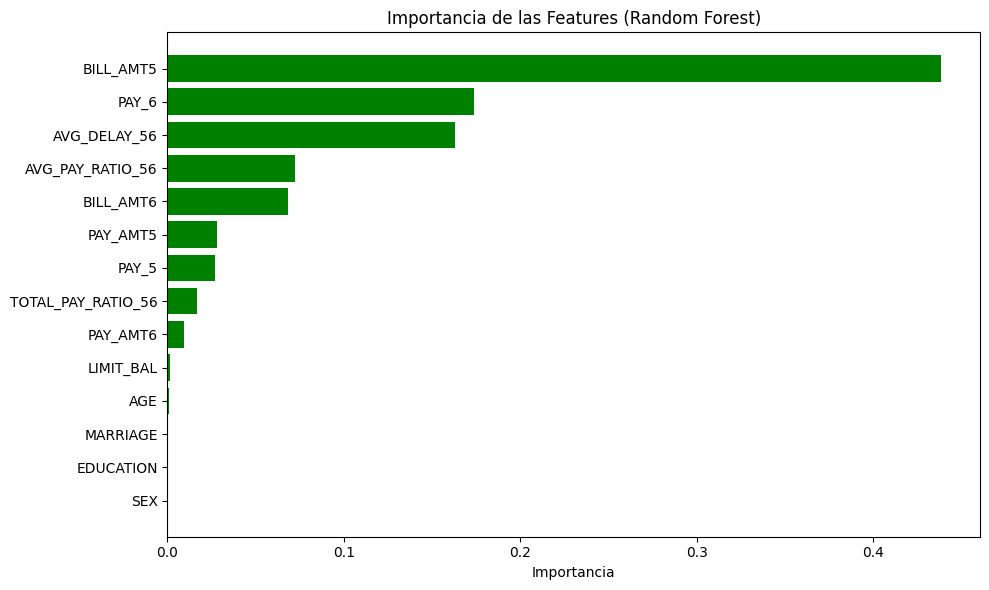

In [268]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="green")
plt.gca().invert_yaxis()
plt.title("Importancia de las Features (Random Forest)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


# **Modelos para predecir la variable default.payment.next.month**

In [277]:
Y_clf = "default payment next month"

X_clf = [
    "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
    "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    "AVG_DELAY_26", "AVG_PAY_RATIO_26", "TOTAL_PAY_RATIO_26"
]


In [278]:
assembler_clf = VectorAssembler(inputCols=X_clf, outputCol="features")
pipeline_clf = Pipeline(stages=[assembler_clf])
model_pipeline_clf = pipeline_clf.fit(df_DFNM)

In [279]:
from pyspark.sql.functions import col, when

df_weighted = df_DFNM.withColumn(
    "classWeight",
    when(col(Y_clf) == 1, 1.0).otherwise(0.3)
)


In [281]:
# Aplica el pipeline
df_weighted_transformed = model_pipeline_clf.transform(df_weighted)

# Ahora sí haces el split
train_clf, test_clf = df_weighted_transformed.randomSplit([0.8, 0.2], seed=1)



In [282]:
from pyspark.ml.classification import LogisticRegression

lr_clf = LogisticRegression(
    featuresCol="features",
    labelCol=Y_clf,
    maxIter=100,
    regParam=0.0,
    elasticNetParam=0.1,
    weightCol="classWeight",
)

In [283]:
lr_model = lr_clf.fit(train_clf)
lr_predictions = lr_model.transform(test_clf)

In [284]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluador binario (AUC)
evaluator_auc = BinaryClassificationEvaluator(
    labelCol=Y_clf, rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluadores para métricas adicionales
evaluator_acc = MulticlassClassificationEvaluator(labelCol=Y_clf, predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=Y_clf, predictionCol="prediction", metricName="f1")

auc = evaluator_auc.evaluate(lr_predictions)
acc = evaluator_acc.evaluate(lr_predictions)
f1 = evaluator_f1.evaluate(lr_predictions)

print("Resultados Logistic Regression:")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


Resultados Logistic Regression:
AUC: 0.6061
Accuracy: 0.7092
F1 Score: 0.7215


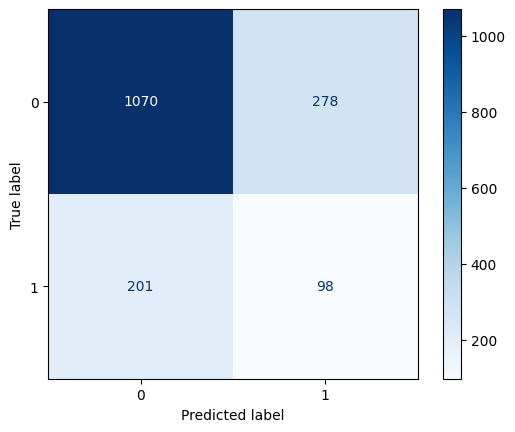

In [285]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convertimos a Pandas
conf_df = lr_predictions.select("prediction", Y_clf).toPandas()

# Redondear predicciones por si no son enteros
conf_df["prediction"] = conf_df["prediction"].round().astype(int)
conf_df[Y_clf] = conf_df[Y_clf].astype(int)

# Crear la matriz
cm = confusion_matrix(conf_df[Y_clf], conf_df["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap="Blues")


In [286]:
from pyspark.ml.classification import RandomForestClassifier

rf_clf = RandomForestClassifier(
    featuresCol="features",
    labelCol=Y_clf,
    numTrees=100,
    maxDepth=15,
    seed=1
)

rf_model = rf_clf.fit(train_clf)
rf_predictions = rf_model.transform(test_clf)


In [287]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluator_auc = BinaryClassificationEvaluator(labelCol=Y_clf, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol=Y_clf, predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=Y_clf, predictionCol="prediction", metricName="f1")

auc = evaluator_auc.evaluate(rf_predictions)
acc = evaluator_acc.evaluate(rf_predictions)
f1 = evaluator_f1.evaluate(rf_predictions)

print("Resultados Random Forest Classifier:")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


Resultados Random Forest Classifier:
AUC: 0.6093
Accuracy: 0.8215
F1 Score: 0.7472


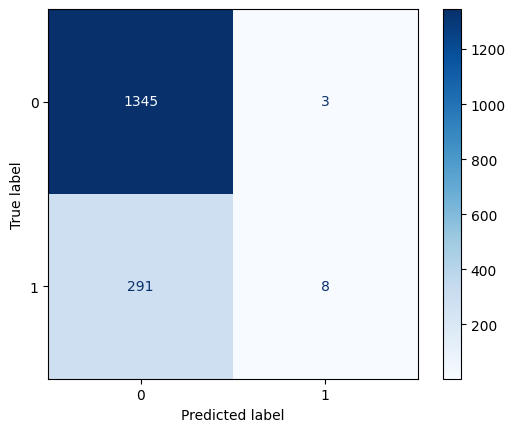

In [288]:

# Convertir a pandas
conf_df_rf = rf_predictions.select("prediction", Y_clf).toPandas()

# Asegurar tipos enteros
conf_df_rf["prediction"] = conf_df_rf["prediction"].round().astype(int)
conf_df_rf[Y_clf] = conf_df_rf[Y_clf].astype(int)

# Calcular matriz
cm = confusion_matrix(conf_df_rf[Y_clf], conf_df_rf["prediction"])

# Mostrar visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap="Blues")


In [289]:
from pyspark.ml.classification import GBTClassifier

gbt_clf = GBTClassifier(
    featuresCol="features",
    labelCol=Y_clf,
    maxIter=50,
    maxDepth=20,
    stepSize=0.1,
    seed=1
)


In [290]:
gbt_model = gbt_clf.fit(train_clf)
gbt_predictions = gbt_model.transform(test_clf)


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

evaluator_auc = BinaryClassificationEvaluator(labelCol=Y_clf, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol=Y_clf, predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=Y_clf, predictionCol="prediction", metricName="f1")

auc = evaluator_auc.evaluate(gbt_predictions)
acc = evaluator_acc.evaluate(gbt_predictions)
f1 = evaluator_f1.evaluate(gbt_predictions)

print("Resultados GBT Classifier:")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


Resultados GBT Classifier:
AUC: 0.5789
Accuracy: 0.7092
F1 Score: 0.7207


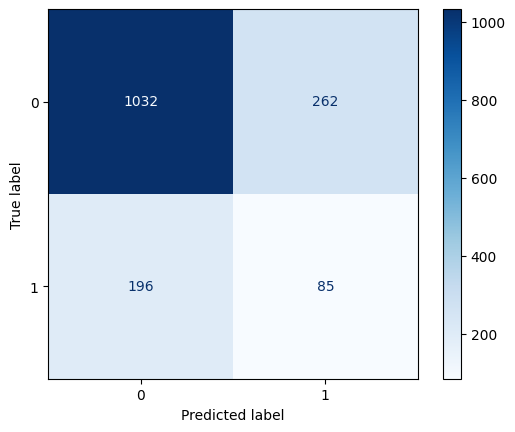

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convertimos a pandas
conf_df_gbt = gbt_predictions.select("prediction", Y_clf).toPandas()

# Asegurar que sean enteros
conf_df_gbt["prediction"] = conf_df_gbt["prediction"].round().astype(int)
conf_df_gbt[Y_clf] = conf_df_gbt[Y_clf].astype(int)
# Crear matriz
cm = confusion_matrix(conf_df_gbt[Y_clf], conf_df_gbt["prediction"])

# Mostrar visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap="Blues")
